# 確率モデル

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import scipy as sp
from scipy.stats import bernoulli, norm, poisson, expon

# 日本語フォントの設定（Mac:'Hiragino Sans', Windows:'MS Gothic'）
plt.rcParams['font.family'] = 'Hiragino Sans'

本章の内容は，文献{cite}`Odaka2018, TokyoUniv2019` を参考にしている．

<!-- ## 確率モデルとは？ -->

確率モデルとは，数理モデルの変数が確率変数となっているモデルであり，自然現象から社会現象まで様々な現象の記述に用いられる．
例えば，コイン投げは，表と裏が一定の確率で出るという数理モデルで記述でき，これは最も基本的な確率モデルである．
また，株価の変動は，毎時刻ごとに株価の上がり幅と下がり幅が確率的に決まるようなモデル（ランダムウォーク）によって記述することができる．
本章では，確率モデルをシミュレーションする際に必要な乱数について述べた後，確率モデルにおいて重要な大数の法則と中心極限定理，そしてランダムウォークについて説明する．


## 乱数の生成

ある数列が与えられたとき，数の並び方に規則性や周期性がない場合，この数列の各要素を**乱数**と呼ぶ．
乱数を生成するにはいくつかの方法がある．
例えば，サイコロを振って出た目を記録するだけでも，1〜6の数値から成る乱数を生成することができる．
また，カオスや量子力学などのランダムな物理現象を利用した乱数は**物理乱数**と呼ばれ，規則性や周期性がない真の乱数として研究されている．

一方，コンピュータ上でアルゴリズムにしたがって乱数を生成する方法もある．
このように生成された乱数は**疑似乱数**と呼ばれる．
疑似乱数はアルゴリズムが分かれば値を予測することができてしまうが，シミュレーションのためには逆にこの性質が長所となる．
また，アルゴリズム次第で十分にランダムに見える値を高速に生成することができることも長所である．
一方，疑似乱数には，ある種の周期性が現れてしまうという欠点があるため，これを解決するための様々なアルゴリズムが提案されている．

### 一様乱数

乱数の中で最も基本的なものは，ある範囲の値が同じ確率で出現する**一様乱数**である．
一様乱数は，一様分布に従う確率変数の実現値と捉えることができ，様々な確率モデルの構築に用いられる．

#### 線形合同法

一様乱数を生成するアルゴリズムの中で，最も基本的なものが**線形合同法**である．
線形合同法にはいくつかの問題があるため，精度が求められる大規模なシミュレーションには使われないが，手軽に乱数を生成したりアルゴリズムの基礎を理解するためには便利である．

```{admonition} 線形合同法のアルゴリズム
1. 以下の条件を満たす整数 $ a, b, M $ を決める：
   
   $$
    0 < a < M\\
    0 \leq b < M
   $$
   
2. 乱数列の初期値 $ x_0 $ を決める（乱数の**シード**と呼ぶ）．
3. 以下の漸化式によって乱数列 $ \{x_n\} $ を生成する：
    
    $$
    x_{n+1} = (ax_{n} + b) \% M
    $$
    
    ここで，$ \% $ は剰余を表す．

```

以上のアルゴリズムを用いると，$ 0 $ 以上 $ M-1 $ 以下の乱数列を得ることができる．
また，$ a, b, M $ がいくつかの条件を満たすと，最大周期が $ M $ となることが知られている {cite}`TokyoUniv2019`．
よって，良い乱数を生成するためには，条件を満たした上で $ M $ が大きい方が良い．
例えば，$ M=2^{32},\ a=1664525,\ b=1013904223 $ の場合には，最大周期が $ 2^{32} $ となる．

**Pythonでの実装**

まず，アルゴリズムに従って素朴に実装すると以下のようになる．

In [73]:
a, b, M = 1664525, 1013904223, 2**32

X = np.array([0])
for i in range(10):
    X = np.append(X, (a*X[i] + b) % M)
print(X)

[         0 1013904223 1196435762 3519870697 2868466484 1649599747
 2670642822 1476291629 2748932008 2180890343 2498801434]


次に，$ x_{\mathrm{min}} $ 以上 $ x_{\mathrm{max}} $ 以下の一様乱数を生成する汎用的な関数を作成する．

In [56]:
# 線形合同法により[0, 1)の一様乱数を生成する
def lcg(seed=0, size=100, xmin=0, xmax=1):
    a, b, M = 1664525, 1013904223, 2**32

    X = np.array([seed])
    for i in range(size-1):
        X = np.append(X, (a*X[i] + b) % M)

    return xmin + (xmax - xmin) * X / M

In [66]:
R = lcg(seed=10, size=1000, xmin=0, xmax=100)

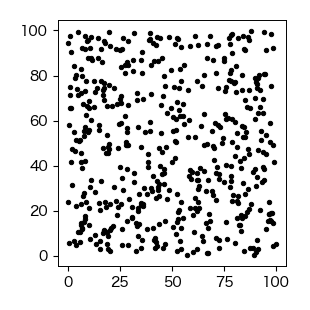

In [70]:
# 乱数列の相関を調べる
R2 = R.reshape(-1, 2)
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(R2[:, 0], R2[:, 1], s=10);

#### より精度の高い一様乱数生成アルゴリズム

Pythonでは，高速で長い周期を持つ一様乱数を生成するために，[メルセンヌ・ツイスタ](http://www.math.sci.hiroshima-u.ac.jp/m-mat/TEACH/ichimura-sho-koen.pdf)と呼ばれるアルゴリズムが採用されている．
特に，Numpyなどで用いられているのは周期が $ 2^{19937}-1 $ であるMT19937というアルゴリズムである．

### 任意の確率分布に従う乱数

#### 逆関数法

ある確率分布に従う乱数を生成したいとする．
いま，求めたい確率分布の累積分布関数を $ F(x) $ とし，その逆関数逆関数 $ F^{-1} $ が計算できるとする．
このとき，$ [0, 1) $ の一様乱数 $ U $ に対し， $ F^{-1}(U) $ を計算すれば，これが求めたい確率分布に従う乱数となる．

以上の手続きを**逆関数法**と呼ぶ．
逆関数法は，累積分布関数の逆関数が求まるような確率分布であれば，どのような確率分布にも適用することができる．

```{admonition} 逆関数法の証明
:class: dropdown

$ [0, 1] $ の範囲の一様乱数を $ U $ とすると，累積分布関数は

$$
    P(U \leq u) = u
$$

と表される．
ここで，求めたい確率分布の累積分布関数を $ F(x) $ とし，その逆関数 $ F^{-1} $ が求まったとする．
このとき，上の式は

$$
    P(F^{-1}(U) \leq F^{-1}(u)) = u
$$

と変形できる．
よって，$ F^{-1}(u) = x $ と変数変換すれば，$ u = F(x) $ であるので，

$$
    P(F^{-1}(U) \leq x) = F(x)
$$

を得る．
以上より，一様乱数 $ U $ に対して，新たな確率変数を $ X=F^{-1}(U) $ と定義すると，$ X $ は求めたい確率分布 $ F(x) $ に従う．
```

**例）指数分布**

指数分布は，確率密度関数以下のように与えられる：

$$
    f(x) = \frac{1}{\lambda} e^{-\frac{x}{\lambda}}
$$

よって，その累積分布関数は

$$
    F(x) = \int_{0}^{x}\frac{1}{\lambda} e^{-\frac{x}{\lambda}} dx = 1 - e^{-\frac{x}{\lambda}}
$$

となり，その逆関数は $ F(x)=u $ と置くと，

$$
    F^{-1}(u) = -\lambda \log(1-u)  
$$

と求まる．
これより，[0, 1)の一様乱数 $ u $ に対して，$ -\lambda \log(1-u) $ は指数分布に従うことが分かる．

以下は，線形合同法を用いて生成した一様乱数から指数乱数を生成する例である．

In [71]:
# 線形合同法で[0, 1)の一様乱数を生成する
R_u = lcg(seed=10, size=1000, xmin=0, xmax=1)

# 逆関数法で指数乱数に変換する
lmd = 1
R_exp = -lmd*np.log(1-R_u)

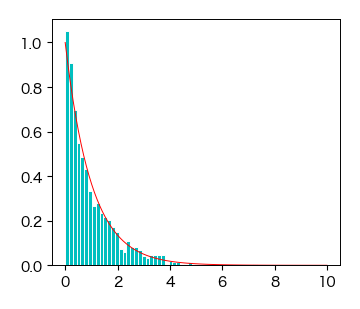

In [72]:
# ヒストグラムの描画
fig, ax = plt.subplots()
ret = ax.hist(R_exp, bins=50, density=1, color='c', edgecolor='w')

# パラメータlmdの指数分布の描画
x = np.linspace(0, 10, 100)
ax.plot(x, expon.pdf(x, scale=lmd), 'r-');

### ボックスミュラー法（正規分布）

正規分布の場合は，中心極限定理（後述）を用いた方法やボックス・ミュラー法が知られている．
ボックスミュラー法は，$ [0, 1) $ の一様乱数 $ U_{1},\ U_{2} $ から標準正規分布に従う正規乱数 $ Z_{1},\ Z_{2} $ を生成することができる．

```{admonition} ボックスミュラー法のアルゴリズム
1. $ [0, 1) $ の一様乱数 $ U_1, U_2 $ を生成する．
2. 以下の式で一様乱数を変換する：

    \begin{align*}
    Z_1 &= \sqrt{-2 \log U_1} \cos(2 \pi U_2)\\
    Z_2 &= \sqrt{-2 \log U_1} \sin(2 \pi U_2)
    \end{align*}

```

#### 複雑な確率分布の場合

逆関数法は累積分布関数の逆関数が求まる場合にしか適用できなかったが，どんな確率分布にも適用できる方法として，[棄却法](https://en.wikipedia.org/wiki/Rejection_sampling)がある．
また，マルコフ連鎖に基づいて任意の確率分布に従う乱数を生成するマルコフ連鎖モンテカルロ法（MCMC）は，主にベイズ推定を始めとして様々な分野で用いられている．

<!-- ## 大数の法則と中心極限定理

### ベルヌーイ試行

### 二項分布

### 大数の法則

### 中心極限定理

## ランダムウォーク -->